<a href="https://colab.research.google.com/github/habibur-rahman-swe/DeepLearningWithKeras/blob/main/MaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import tensorflow
from tensorflow import keras
from keras.preprocessing. image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [75]:
# initialize ther initial learing rate, number of epochs to train for and batch size
INIT_LR = 1e-4
EPOCHS = 2
BS = 32
DIRECTORY = "/content/mask-nonmask-data"

In [76]:
data = []
labels = []

for category in os.listdir(DIRECTORY):
  path = os.path.join(DIRECTORY, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

print(labels[:10])

['with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask']


In [77]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [78]:
labels[:-10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [79]:
# train and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [80]:
# construct the training image generate for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [81]:
# Create TensorFlow dataset
train_dataset = tensorflow.data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.shuffle(buffer_size=len(trainX)).batch(BS)

# Repeat the dataset indefinitely
train_dataset = train_dataset.repeat()

# Calculate steps per epoch
steps_per_epoch = len(trainX) // BS

In [82]:
# load the mobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [83]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [84]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [85]:
# loop over all layers in the base moodel and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
  layer.trainable = False

In [86]:
# compile out model
print('[INFO] compiling model...')
opt = keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [87]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

[INFO] training head...
Epoch 1/2
15/15 [==============================] - 40s 2s/step - loss: 0.6814 - accuracy: 0.6792 - val_loss: 0.4401 - val_accuracy: 0.9750
Epoch 2/2
15/15 [==============================] - 31s 2s/step - loss: 0.4242 - accuracy: 0.9167 - val_loss: 0.2836 - val_accuracy: 0.9917


In [88]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
4/4 [==============================] - 7s 1s/step


In [89]:

# for each image in the testing set we need to find the index of the label with corresponding larget predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.98      0.99        60
without_mask       0.98      1.00      0.99        60

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [90]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("my_model.keras", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


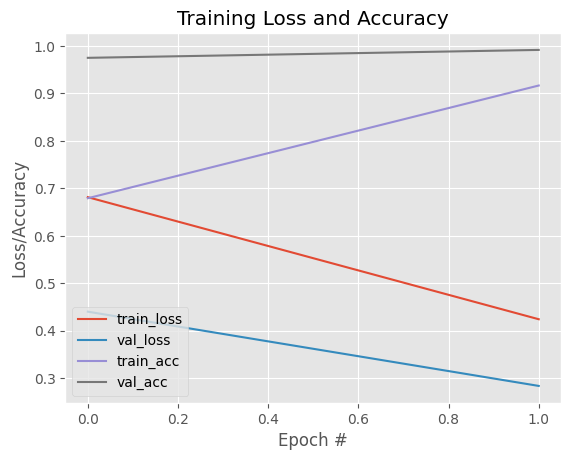

In [91]:

# plot the training Loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.png")